In [1]:
import pandas as pd
import json

<h2>Preprocessing</h2>

In [2]:
file = r"D:\Universite\Term8\Data Science\Data-Science-Course-spring2025\CA-5-6\PerCQA_JSON_Format.json"
with open(file, 'r', encoding='utf-8-sig') as f:
    raw = json.load(f)
if isinstance(raw, list):
    data = pd.DataFrame(raw)
else:
    data = pd.json_normalize(raw)
    

print(data.columns)


Index(['QID', 'QCATEGORY', 'QDATE', 'QUSERID', 'QTYPE', 'QGOLD_YN',
       'QUsername', 'QBody', 'QSubject', 'Comments'],
      dtype='object')


In [3]:
print(data['Comments'])

0      [{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':...
1      [{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':...
2      [{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'...
3      [{'CID': '138006316', 'CUSERID': 38437, 'CGOLD...
4      [{'CID': '100859930', 'CUSERID': 33391, 'CGOLD...
                             ...                        
985    [{'CID': '52145320', 'CUSERID': 10177, 'CGOLD'...
986    [{'CID': '59550231', 'CUSERID': 13736, 'CGOLD'...
987    [{'CID': '51780636', 'CUSERID': 9563, 'CGOLD':...
988    [{'CID': '131471418', 'CUSERID': 6245, 'CGOLD'...
989    [{'CID': '51675328', 'CUSERID': 9609, 'CGOLD':...
Name: Comments, Length: 990, dtype: object


In [4]:
import re
from hazm import Normalizer, word_tokenize, stopwords_list, Lemmatizer

normalizer = Normalizer()
lemmatizer = Lemmatizer()
stopwords = set(stopwords_list())

arabic_to_persian = str.maketrans({"ي": "ی", "ك": "ک"})
tatweel_pattern = re.compile(r'[ـ]+')
space_pattern = re.compile(r'\s+')
diacritics_pattern = re.compile(r'[\u064B-\u0652]+')


def canonicalize_slangs(text):
    
    text = re.sub(r'خ{2,}', 'خخخ', text)
    
    text = re.sub(r'عه{2,}', 'عههه', text)
    
    text = re.sub(r'(مر){2,}', 'مر', text)
    return text

slang_mapping = {
    "خخخ": "خنده",
    "عههه": "تعجب",
    "سلاممم": "سلام",
    "lol": "خنده",
    "thx": "تشکر",
    
}

emoji_pattern = re.compile(
    "[" 
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002700-\U000027BF"  # dingbats
    u"\U000024C2-\U0001F251"  # enclosed chars
    "]+",
    flags=re.UNICODE
)
import string


punctuation_pattern = re.compile(r'[{}«»،؛؟!٪…]'.format(re.escape(string.punctuation)))

def remove_punctuation(text):
    if not isinstance(text, str):
        return text
    return punctuation_pattern.sub(' ', text)


def remove_emojis(text):
    if not isinstance(text, str):
        return text
    return emoji_pattern.sub(r'', text)

def replace_slangs_mapping(text):
    for k, v in slang_mapping.items():
        text = text.replace(k, v)
    return text


repetition_pattern = re.compile(r'(.)\1+', re.UNICODE)

def normalize_repetition_chars(text):
    return repetition_pattern.sub(r'\1', text)

In [5]:

def preprocess_text(text):
    if not isinstance(text, str):
        return []

    t = remove_emojis(text)
    t = text.translate(arabic_to_persian)
    t = tatweel_pattern.sub('', t)
    t = diacritics_pattern.sub('', t)
    t = space_pattern.sub(' ', t).strip()
    t = remove_punctuation(t)
    t = canonicalize_slangs(t)

    t = replace_slangs_mapping(t)

    t = normalize_repetition_chars(t)

    t = normalizer.normalize(t)

    tokens = word_tokenize(t)

    tokens = [tok for tok in tokens if tok and tok not in stopwords]

    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]

    return tokens


In [6]:
import re
persian_pattern = re.compile(r'[\u0600-\u06FF]')
def has_persian(series):
    return series.astype(str).apply(lambda x: bool(persian_pattern.search(x))).any()

In [7]:
comments = []
for q in raw:
    for c in q.get('Comments', []):
        comments.append(c)
comments_df = pd.DataFrame(comments)

cols_to_normalize = []
for col in data.columns:
    if has_persian(data[col]):
        cols_to_normalize.append(("questions", col))
for col in comments_df.columns:
    if has_persian(comments_df[col]):
        cols_to_normalize.append(("comments", col))

print("Columns with Persian text:", cols_to_normalize)

Columns with Persian text: [('questions', 'QUsername'), ('questions', 'QBody'), ('questions', 'QSubject'), ('questions', 'Comments'), ('comments', 'CBody'), ('comments', 'CBodyClean'), ('comments', 'CUsername')]


In [8]:
import swifter

for df_name, col in cols_to_normalize:
    if df_name == "questions":
        data[col + "_prep"] = data[col].map(preprocess_text)
    elif df_name == "comments":
        comments_df[col + "_prep"] = comments_df[col].map(preprocess_text)




In [9]:
print(data.columns)

Index(['QID', 'QCATEGORY', 'QDATE', 'QUSERID', 'QTYPE', 'QGOLD_YN',
       'QUsername', 'QBody', 'QSubject', 'Comments', 'QUsername_prep',
       'QBody_prep', 'QSubject_prep', 'Comments_prep'],
      dtype='object')


In [10]:
print(comments_df.columns)

Index(['CID', 'CUSERID', 'CGOLD', 'CGOLD_YN', 'CSubject', 'CBody',
       'CBodyClean', 'CUsername', 'CDate', 'LabelDate', 'ReplayCommentId',
       'CBody_prep', 'CBodyClean_prep', 'CUsername_prep'],
      dtype='object')


In [11]:
sample = ". سبد و جعبه هارو كه نبايد برگردوني🙄🙄🙄"
print(preprocess_text(sample))


['سبد', 'جعبه', 'هارو', 'برگردونی🙄']


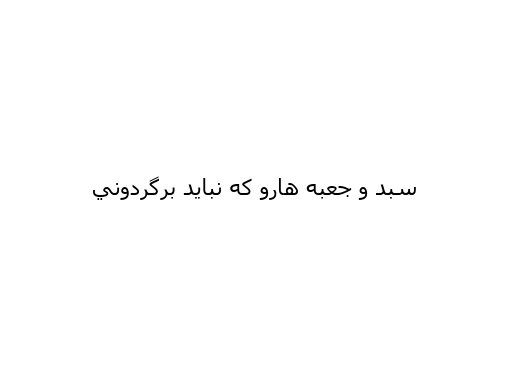

In [12]:
import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import pyplot as plt
text_to_be_reshaped = " سبد و جعبه هارو كه نبايد برگردوني"
i = arabic_reshaper.reshape(text_to_be_reshaped)
bidi_text = get_display(i)

plt.text(0.5, 0.5, bidi_text, fontsize=16, ha='center', fontname="Tahoma")
plt.axis("off")
plt.show()

<h2>EDA</h2>

In [13]:
displayed_question = data['QBody'][0]
print(displayed_question)
displayed_answer = data['Comments'][0][0]['CBody']
print(displayed_answer)

دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چه کنم؟موضوع دعوامون چیزی بوده که من مقصرش نیستم...خودشم میدونه ربطی به من نداره
قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و همین ابتدای زندگیت محوش کن عزیزم


In [14]:

for df, df_name in [(data, "questions"), (comments_df, "comments")]:
    for col in df.columns:
        if col.endswith("_prep"):
            df[col + "_word_len"] = df[col].apply(lambda x: len(x) if isinstance(x, list) else 0)
            
            df[col + "_char_len"] = df[col].apply(
                lambda x: len(" ".join(x)) if isinstance(x, list) else 0
            )
            

In [15]:
import numpy as np
def summarize_stats(series, name):
    avg = np.mean(series)
    median = np.median(series)
    print(f"{name} - Average: {avg:.2f}, Median: {median:.2f}")
    
for df_name, df in [("questions", data), ("comments", comments_df)]:
    for col in df.columns:
        if col.endswith("_word_len"):
            summarize_stats(df[col], f"{df_name} {col} (words)")
        if col.endswith("_char_len"):
            summarize_stats(df[col], f"{df_name} {col} (chars)")

questions QUsername_prep_word_len (words) - Average: 1.60, Median: 2.00
questions QUsername_prep_char_len (chars) - Average: 8.48, Median: 8.00
questions QBody_prep_word_len (words) - Average: 23.12, Median: 17.50
questions QBody_prep_char_len (chars) - Average: 126.41, Median: 94.50
questions QSubject_prep_word_len (words) - Average: 3.89, Median: 4.00
questions QSubject_prep_char_len (chars) - Average: 20.31, Median: 19.00
questions Comments_prep_word_len (words) - Average: 0.00, Median: 0.00
questions Comments_prep_char_len (chars) - Average: 0.00, Median: 0.00
comments CBody_prep_word_len (words) - Average: 13.55, Median: 9.00
comments CBody_prep_char_len (chars) - Average: 72.26, Median: 50.00
comments CBodyClean_prep_word_len (words) - Average: 12.65, Median: 9.00
comments CBodyClean_prep_char_len (chars) - Average: 67.77, Median: 47.00
comments CUsername_prep_word_len (words) - Average: 1.65, Median: 2.00
comments CUsername_prep_char_len (chars) - Average: 8.27, Median: 8.00


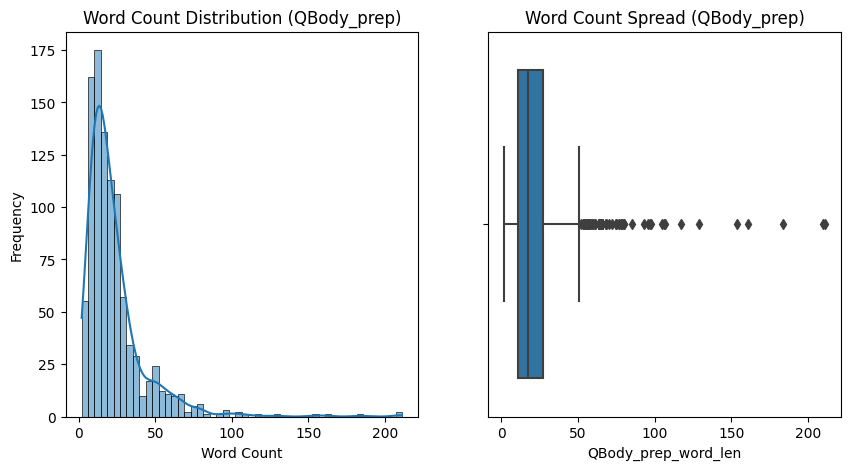

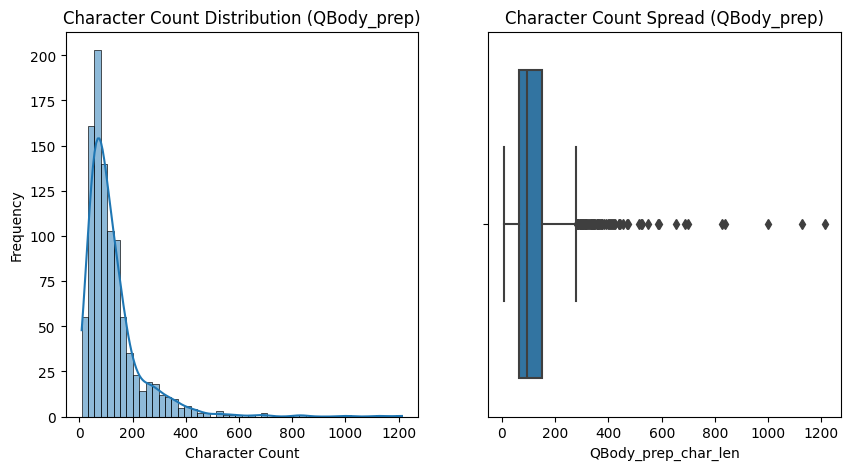

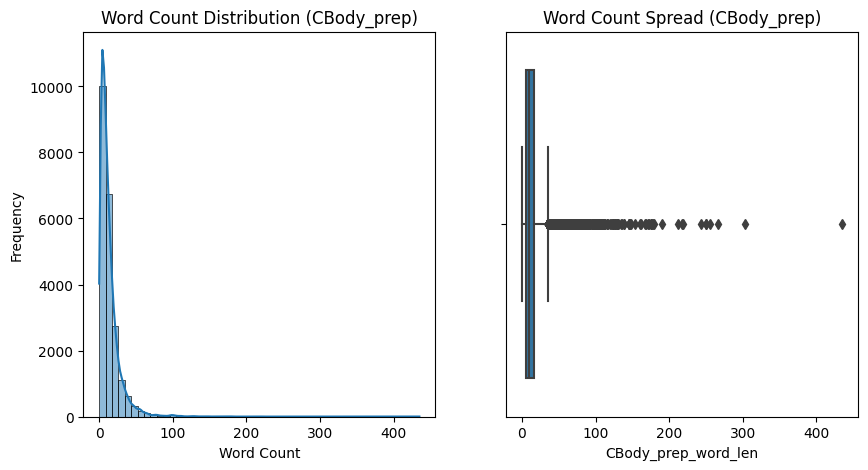

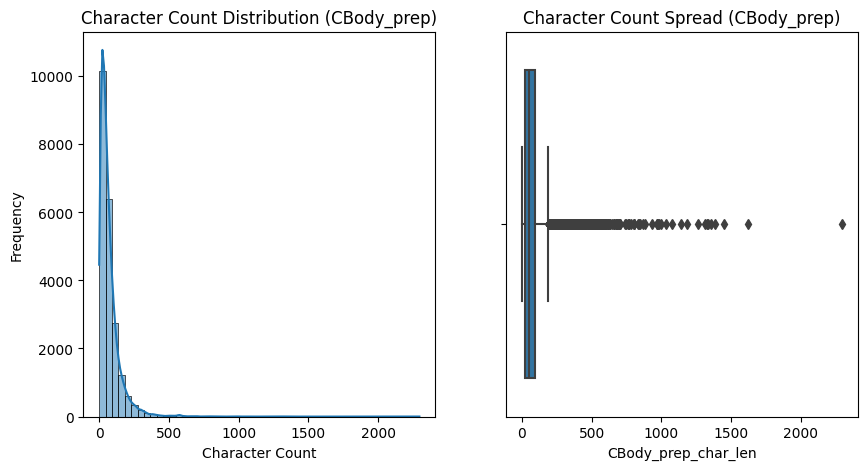

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_lengths(df, text_col):
    # Word lengths
    word_lengths = df[text_col + "_word_len"].dropna()
    char_lengths = df[text_col + "_char_len"].dropna()
    
    plt.figure(figsize=(10,5))

    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(word_lengths, bins=50, kde=True)
    plt.title(f"Word Count Distribution ({text_col})")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=word_lengths)
    plt.title(f"Word Count Spread ({text_col})")

    plt.show()

    plt.figure(figsize=(10,5))
    
    # Histogram for characters
    plt.subplot(1,2,1)
    sns.histplot(char_lengths, bins=50, kde=True)
    plt.title(f"Character Count Distribution ({text_col})")
    plt.xlabel("Character Count")
    plt.ylabel("Frequency")
    
    # Boxplot for characters
    plt.subplot(1,2,2)
    sns.boxplot(x=char_lengths)
    plt.title(f"Character Count Spread ({text_col})")

    plt.show()

# Example usage (on a normalized QBody column)
visualize_lengths(data, "QBody_prep")
visualize_lengths(comments_df, "CBody_prep")


In [17]:
def most_engaging_questions(data, top_n=5):
    data['num_comments'] = data['Comments'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    top_questions = data.nlargest(top_n, 'num_comments')
    return top_questions[['QID', 'num_comments']]
print(most_engaging_questions(data, top_n=5))

         QID  num_comments
571  1556257           315
152  1577970           313
342  1559359           215
728  1555428           215
194  1578477           166


In [18]:
print(data['QTYPE'])

0      General
1      General
2      General
3      General
4      General
        ...   
985    General
986    General
987    General
988    General
989    General
Name: QTYPE, Length: 990, dtype: object


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
def analyze_hourly_patterns(df):
    hourly_counts = df['hour'].value_counts().sort_index()
    plt.figure(figsize=(10,5))
    sns.barplot(x = hourly_counts.index, y = hourly_counts.values, palette="viridis")
    plt.title("Activity by Hour of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Comments")
    plt.show()
    
def analyze_daily_patterns(df):
    daily_counts = df['day'].value_counts().reindex(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    )
    plt.figure(figsize=(10,6))
    sns.barplot(x=daily_counts.index, y=daily_counts.values, palette="coolwarm")
    plt.title("Activity by Day of Week")
    plt.xlabel("Day")
    plt.ylabel("Number of Comments")
    plt.show()
    
def analyze_heatmap(df):
    heatmap_data = df.groupby(['day', 'hour']).size().unstack(fill_value=0).reindex(
        index=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plt.figure(figsize=(10,6))
    sns.heatmap(heatmap_data, cmap="YlGnBu")
    plt.title("Heatmap of Comments by Day and Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.show()    

In [20]:
def date_preprocess():
    comments_df['CDate'] = pd.to_datetime(comments_df['CDate'], errors='coerce')
    comments_df['hour'] = comments_df['CDate'].dt.hour
    comments_df['date'] = comments_df['CDate'].dt.date
    comments_df['day'] = comments_df['CDate'].dt.day_name()
    return comments_df

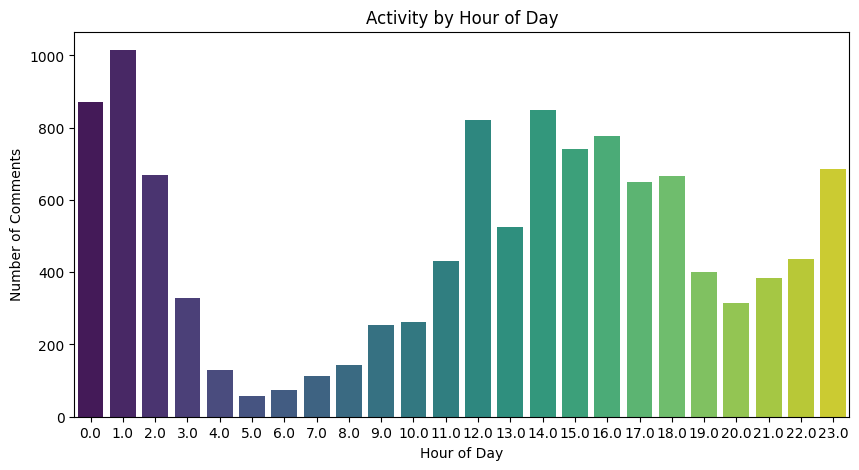

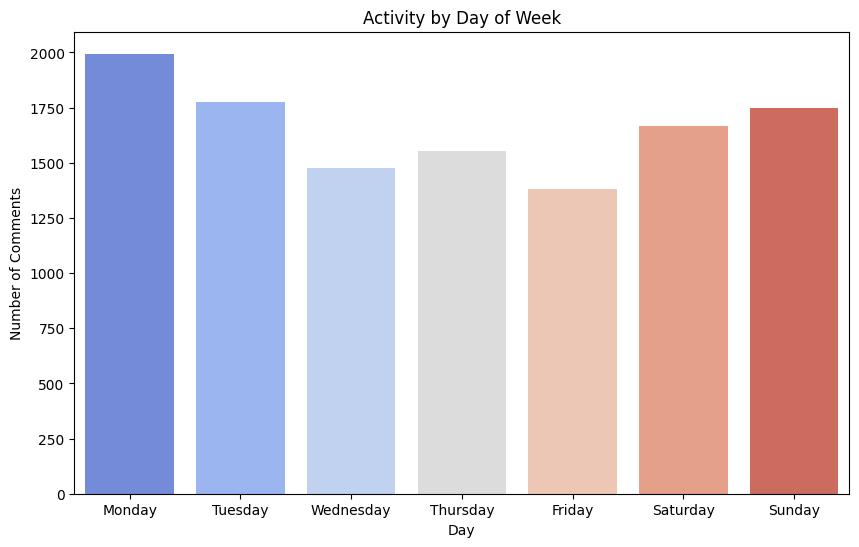

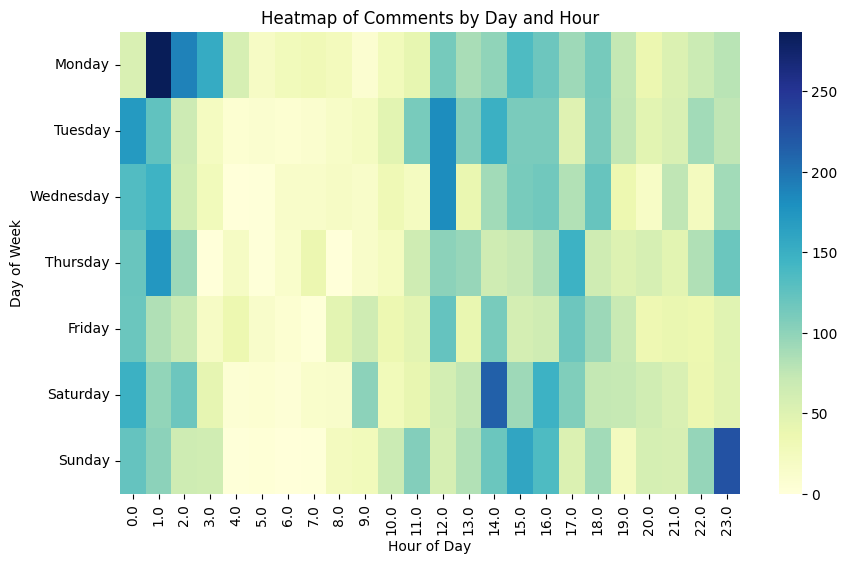

In [21]:
def analyze_activity_patterns():
    comments_df = date_preprocess()
    analyze_hourly_patterns(comments_df)
    analyze_daily_patterns(comments_df)
    analyze_heatmap(comments_df)
analyze_activity_patterns()

In [22]:
def fix_persian_text(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)

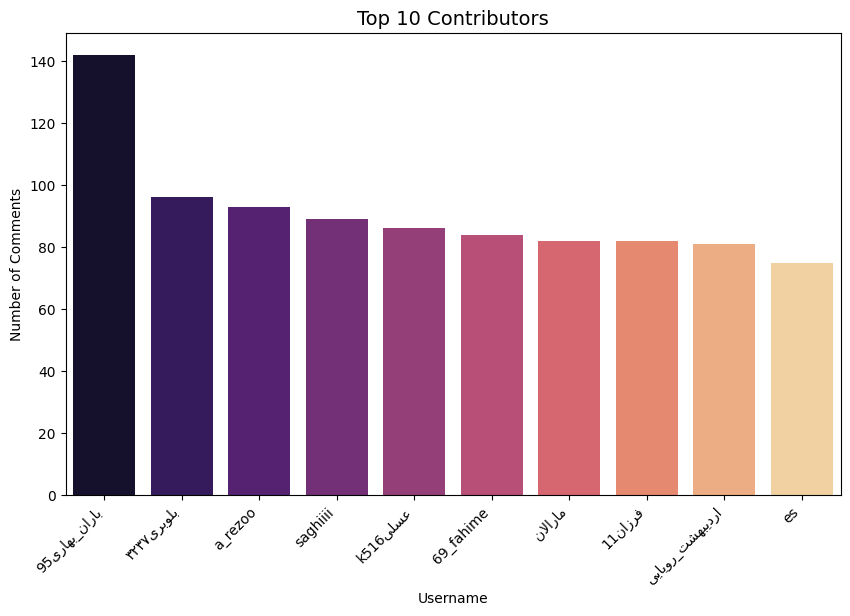

In [23]:
def show_top_contributers(top_n=10):
    usernames = comments_df['CUsername'].value_counts().head(top_n)
    usernames.index = [fix_persian_text(str(u)) for u in usernames.index]  
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=usernames.index, y=usernames.values, palette="magma")
    plt.title(f"Top {top_n} Contributors", fontsize=14)
    plt.xlabel("Username")
    plt.ylabel("Number of Comments")
    plt.xticks(rotation=45, ha="right")
    plt.show()
show_top_contributers()


In [24]:
from collections import Counter
def analyze_frequent_words(df, text_col, top_n=10):
    all_words = [tok for tokens in df[text_col].dropna() for tok in tokens if isinstance(tokens, list)]
    counter = Counter(all_words)
    most_common = counter.most_common(top_n)
    return most_common


In [25]:
def plot_top_words(word_freq, title):
    words, counts = zip(*word_freq)
    words = [fix_persian_text(str(u)) for u in words]
    plt.figure(figsize=(12,6))
    sns.barplot(x=list(words), y=list(counts), palette="viridis")
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Frequency")
    plt.xlabel("Word")
    plt.show()

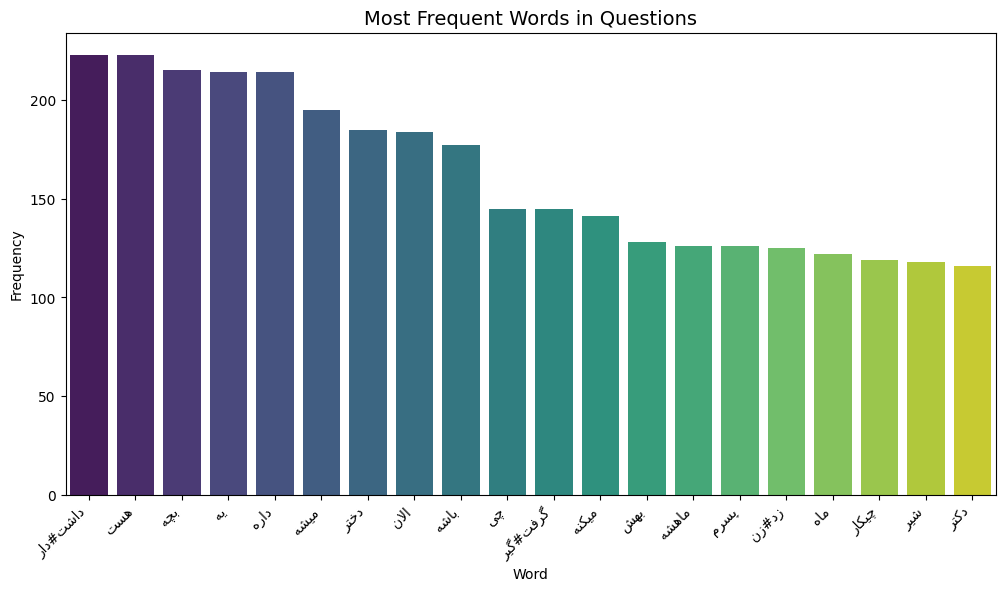

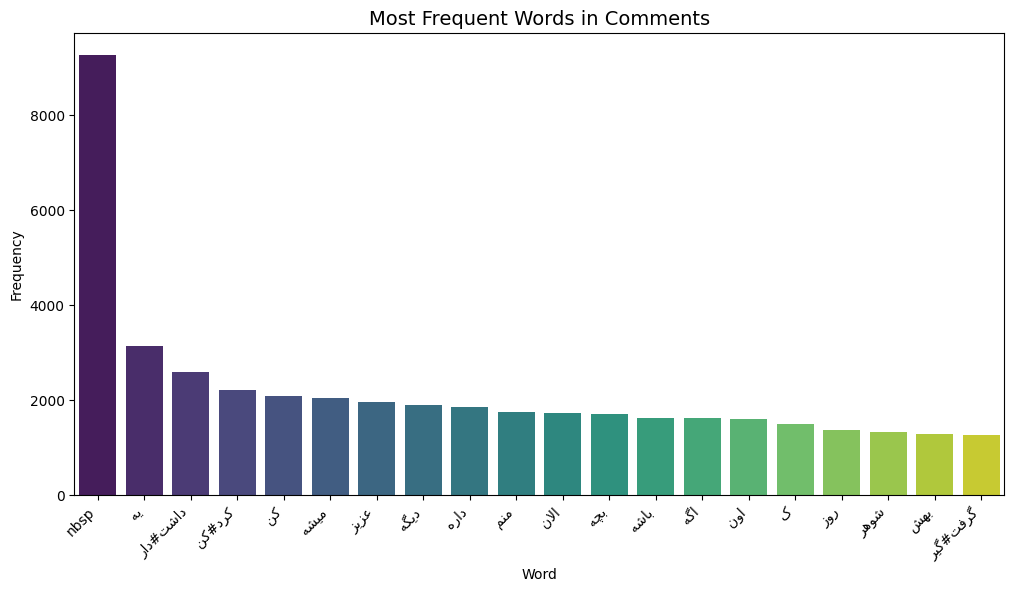

In [26]:
q_top_words = analyze_frequent_words(data, "QBody_prep", top_n=20)
plot_top_words(q_top_words, "Most Frequent Words in Questions")


c_top_words = analyze_frequent_words(comments_df, "CBody_prep", top_n=20)
plot_top_words(c_top_words, "Most Frequent Words in Comments")

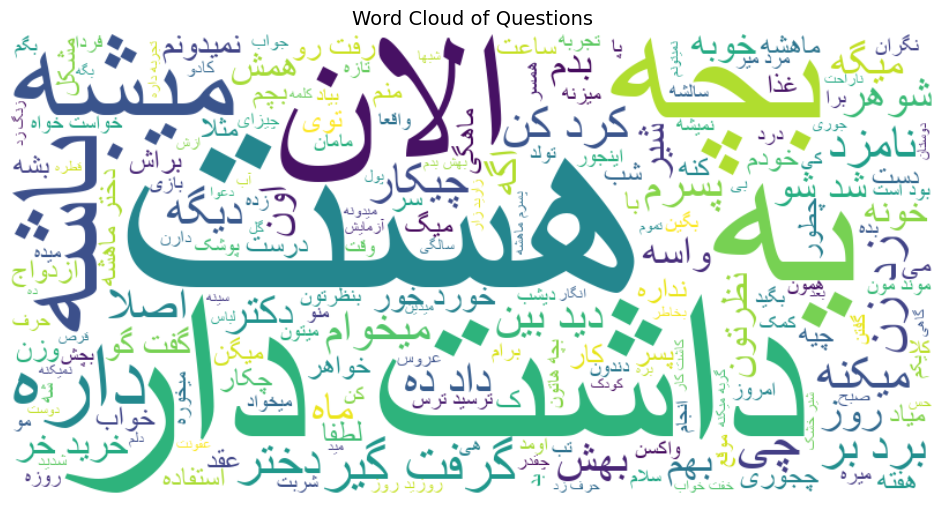

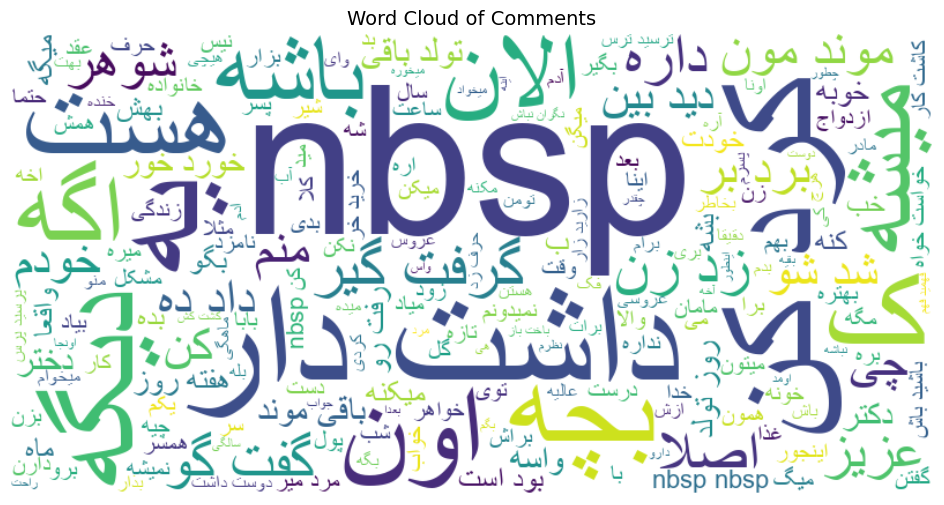

In [27]:
from wordcloud import WordCloud

def show_wordcloud(df, col, title):
    all_tokens = [tok for tokens in df[col].dropna() for tok in tokens if isinstance(tokens, list)]
    text = " ".join(all_tokens)
    wc = WordCloud(
        font_path="C:/Windows/Fonts/Arial.ttf",  
        background_color="white",
        width=800, height=400
    ).generate(text)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Example
show_wordcloud(data, "QBody_prep", "Word Cloud of Questions")
show_wordcloud(comments_df, "CBody_prep", "Word Cloud of Comments")


<h2>Dataset Analysis</h2>

In [ ]:
import lancedb
from typing import ClassVar
from lancedb.embeddings import TextEmbeddingFunction
from lancedb.embeddings import register
from lancedb.util import attempt_import_or_raise

from transformers import AutoTokenizer, AutoModel
import torch
import random

model_name = "BAAI/bge-m3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, use_safetensors=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

@register("bge-embedding-transformer")
class BGEEmbedding(TextEmbeddingFunction):
    name: ClassVar[str] = "bge-m3"
    dim: ClassVar[int] = 1024
    device: ClassVar[str] = device

    def ndims(self) -> int:
        return self.dim

    def generate_embeddings(self, texts):
        
        if isinstance(texts, str):
            texts = [texts]

        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = mean_pooling(outputs, inputs["attention_mask"])
        return embeddings.cpu().numpy()
    # @cached(cache={})
    # def _embedding_model(self):
    #     return bge-embedding-transformer.SentenceTransformer(name)

model.safetensors:  38%|###7      | 1.38G/3.66G [00:00<?, ?B/s]

In [ ]:
import pyarrow as pa
import lancedb
from lancedb.embeddings import EmbeddingFunctionRegistry
from lancedb.pydantic import LanceModel, Vector

db = lancedb.connect("./lancedb")

registry = EmbeddingFunctionRegistry.get_instance()
transformer_conf = registry.get("bge-embedding-transformer").create()

class QSchema(LanceModel):
    embedding: Vector = transformer_conf.VectorField()   # uses registered function
    qid: int
    qbody: str = transformer_conf.SourceField()

table_name = "questions_auto"
tbl = db.create_table("table", schema=QSchema, mode = "overwrite")

rows = []
for idx, q in enumerate(data["QBody"].dropna().astype(str)):
    rows.append({"qid": int(idx), "qbody": q})

tbl.add(rows[:200])  


 Retrying in 3.8416448022410328 seconds (retry 1 of 7) 

 Retrying in 14.961807027824781 seconds (retry 2 of 7) 

 Retrying in 53.297821252082855 seconds (retry 3 of 7) 

 Retrying in 206.80986705475894 seconds (retry 4 of 7) 

 Retrying in 436.5241902211936 seconds (retry 5 of 7) 

 Retrying in 1262.820849946211 seconds (retry 6 of 7) 

 Retrying in 4766.433618093712 seconds (retry 7 of 7) 



In [ ]:

queries = [
    "چطور می‌توانم با همسرم بهتر صحبت کنم؟",
    "علت اضطراب من چیست؟",
    "چگونه خواب بهتری داشته باشم؟",
    "چطور وزن کم کنم؟",
    "آیا مصرف دارو باعث عوارض می‌شود؟"
]

for q in queries:
    print("QUERY:", q)
    res = tbl.search(q).limit(5).to_pandas()
    print(res[["qid", "qbody", "_distance"]])
    print("-"*80)


In [ ]:

try:
    tbl.create_index("qbody", index_type="text", analyzer="standard")  
    print("Created full-text index on qbody")
    ft_results = tbl.search_text("صحبت با همسر", limit=5).to_pandas()  
    print(ft_results[["qid","qbody","_score"]])
except Exception as e:
    print("LanceDB text index API not available or failed:", e)
    print("Will use TF-IDF fallback for full-text search.")


Compare semantic vs full-text

Semantic search (embeddings) finds paraphrases and  similar texts even when vocabulary differs.

Full-text (TF-IDF / text index) matches documents with overlapping tokens and exact words; works well when user uses same words as contained docs.



Hybrid search combines full-text relevance signals and dense vector similarity. some approaches are:

Compute both TF-IDF (or BM25) score and embedding similarity, then combine (e.g., alpha * embed_score + (1-alpha) * tfidf_score) and rank by the combined score.

Or use a two-stage pipeline: use text index to retrieve a candidate set (fast), then rerank those candidates with embeddings for semantic relevance.

overall why is effective: full-text is precise for keyword matches. embeddings capture semantics. Hybrid reduces false positives/negatives from either method used alone.

Precision@k: fraction of top-k results that are relevant.

Recall@k: fraction of all relevant docs that appear in top-k.

NDCG@k (Normalized Discounted Cumulative Gain): accounts for relevance levels and ranks (higher ranked relevant docs contribute more).

MAP (Mean Average Precision): averages precision at ranks where relevant documents appear.